In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [51]:
df = pd.read_csv(r"^SPX.csv")

In [52]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-01,167.199997,180.270004,163.360001,179.630005,179.630005,2.673710e+09
1,1985-02-01,179.630005,183.949997,177.750000,181.179993,181.179993,2.194620e+09
2,1985-03-01,181.179993,183.889999,176.529999,180.660004,180.660004,2.153090e+09
3,1985-04-01,180.660004,183.610001,177.860001,179.830002,179.830002,1.981880e+09
4,1985-05-01,179.830002,189.979996,178.350006,189.550003,189.550003,2.350340e+09
...,...,...,...,...,...,...,...
468,2024-01-01,4745.200195,4931.089844,4682.109863,4845.649902,4845.649902,8.173788e+10
469,2024-02-01,4861.109863,5111.060059,4853.520020,5096.270020,5096.270020,8.206693e+10
470,2024-03-01,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,8.629951e+10
471,2024-04-01,5257.970215,5263.950195,4953.560059,5035.689941,5035.689941,8.174717e+10


## PRE PROCESSING

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       473 non-null    object 
 1   Open       472 non-null    float64
 2   High       472 non-null    float64
 3   Low        472 non-null    float64
 4   Close      472 non-null    float64
 5   Adj Close  472 non-null    float64
 6   Volume     472 non-null    float64
dtypes: float64(6), object(1)
memory usage: 26.0+ KB


In [54]:
df.isna().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [55]:
df.dropna(inplace=True)

In [56]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## NORMALIZATION

In [57]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,472.000000,472.000000,472.000000,472.000000,472.000000,4.720000e+02
mean,1439.974023,1489.312628,1390.076970,1449.396058,1449.396058,4.573510e+10
std,1149.495762,1189.478176,1109.672548,1158.195428,1158.195428,3.854485e+10
min,167.199997,180.270004,163.360001,179.630005,179.630005,1.860160e+09
25%,469.772506,477.064995,460.705009,471.867508,471.867508,6.349822e+09
50%,1180.929993,1219.695007,1129.734985,1180.929993,1180.929993,3.158255e+10
75%,1920.705017,1964.262482,1824.105011,1925.344971,1925.344971,7.957303e+10
max,5257.970215,5264.850098,5056.819824,5254.350098,5254.350098,1.621854e+11


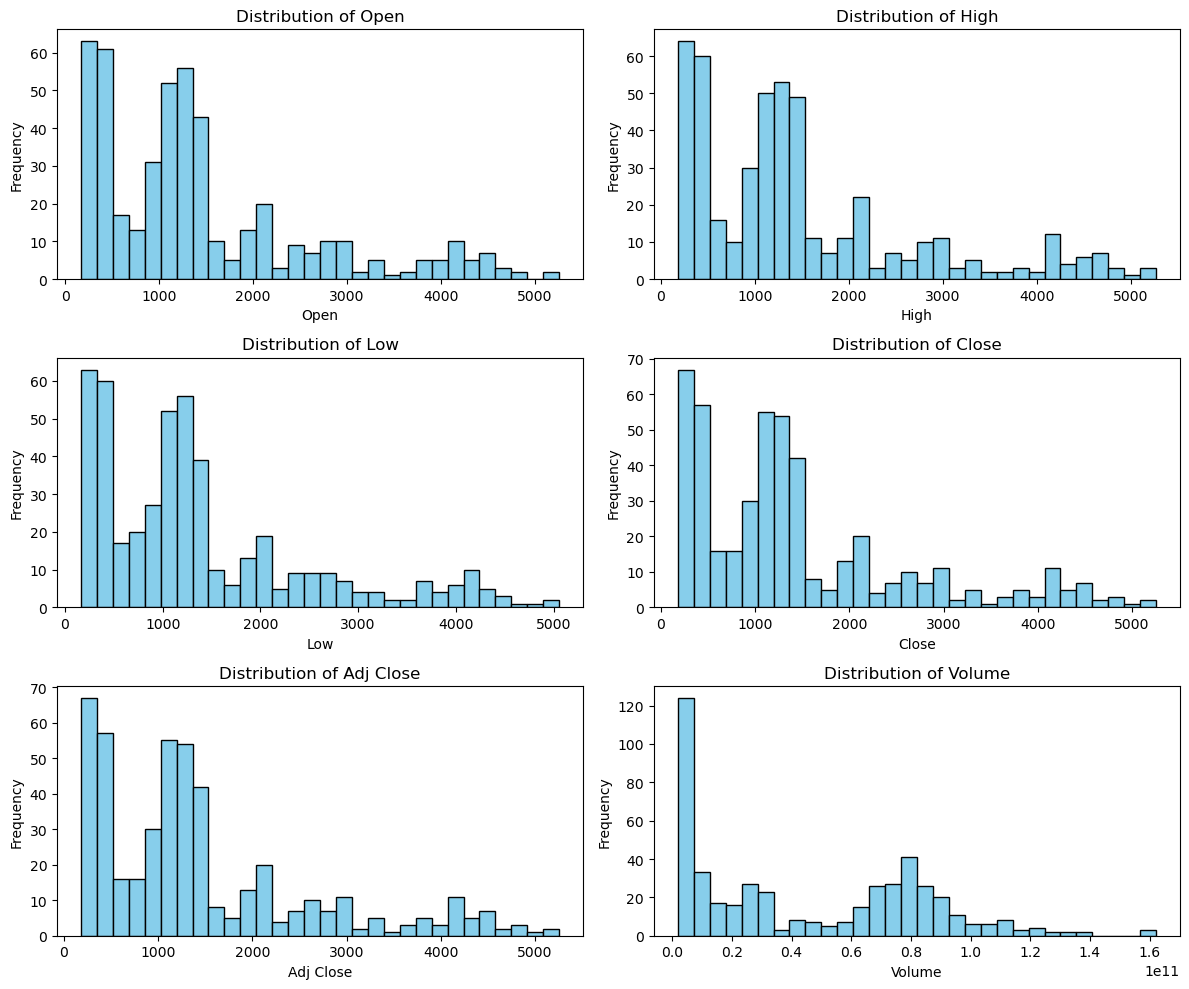

In [58]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for i, column in enumerate(numerical_columns):
    ax = axes[i]
    ax.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [59]:
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data_to_normalize = df[numerical_columns]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_df = pd.DataFrame(normalized_data, columns=numerical_columns)

In [60]:
normalized_df

,Open,High,Low,Close,Adj Close,Volume
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005074
1,0.002442,0.000724,0.002941,0.000305,0.000305,0.002086
2,0.002746,0.000712,0.002691,0.000203,0.000203,0.001827
3,0.002644,0.000657,0.002963,0.000039,0.000039,0.000759
4,0.002481,0.001910,0.003063,0.001955,0.001955,0.003057
...,...,...,...,...,...,...
467,0.862783,0.907259,0.895714,0.904523,0.904523,0.496931
468,0.899275,0.934358,0.923426,0.919463,0.919463,0.498223
469,0.922043,0.969754,0.958455,0.968849,0.968849,0.500275
470,0.968677,1.000000,1.000000,1.000000,1.000000,0.526675


In [61]:
normalized_df['Date'] = df['Date']

In [62]:
normalized_df

,Open,High,Low,Close,Adj Close,Volume,Date
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005074,1985-01-01
1,0.002442,0.000724,0.002941,0.000305,0.000305,0.002086,1985-02-01
2,0.002746,0.000712,0.002691,0.000203,0.000203,0.001827,1985-03-01
3,0.002644,0.000657,0.002963,0.000039,0.000039,0.000759,1985-04-01
4,0.002481,0.001910,0.003063,0.001955,0.001955,0.003057,1985-05-01
...,...,...,...,...,...,...,...
467,0.862783,0.907259,0.895714,0.904523,0.904523,0.496931,2023-12-01
468,0.899275,0.934358,0.923426,0.919463,0.919463,0.498223,2024-01-01
469,0.922043,0.969754,0.958455,0.968849,0.968849,0.500275,2024-02-01
470,0.968677,1.000000,1.000000,1.000000,1.000000,0.526675,2024-03-01


## Stationarization

### Differencing

In [63]:
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for column in numerical_columns:
    normalized_df[f'{column}_diff'] = normalized_df[column].diff()

### Logarithmic

In [64]:
for column in numerical_columns:
    normalized_df[f'{column}_log'] = normalized_df[column].apply(lambda x: np.log(x) if x != 0 else 0)

In [65]:
normalized_df

,Open,High,Low,Close,Adj Close,Volume,Date,Open_diff,High_diff,Low_diff,Close_diff,Adj Close_diff,Volume_diff,Open_log,High_log,Low_log,Close_log,Adj Close_log,Volume_log
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005074,1985-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-5.283552
1,0.002442,0.000724,0.002941,0.000305,0.000305,0.002086,1985-02-01,0.002442,0.000724,0.002941,0.000305,0.000305,-0.002988,-6.015071,-7.231057,-5.829121,-8.093779e+00,-8.093779e+00,-6.172442
2,0.002746,0.000712,0.002691,0.000203,0.000203,0.001827,1985-03-01,0.000304,-0.000012,-0.000249,-0.000102,-0.000102,-0.000259,-5.897557,-7.247495,-5.917713,-8.502469e+00,-8.502469e+00,-6.305026
3,0.002644,0.000657,0.002963,0.000039,0.000039,0.000759,1985-04-01,-0.000102,-0.000055,0.000272,-0.000164,-0.000164,-0.001068,-5.935462,-7.327998,-5.821506,-1.014148e+01,-1.014148e+01,-7.183236
4,0.002481,0.001910,0.003063,0.001955,0.001955,0.003057,1985-05-01,-0.000163,0.001253,0.000100,0.001915,0.001915,0.002298,-5.999109,-6.260812,-5.788271,-6.237474e+00,-6.237474e+00,-5.790187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,0.862783,0.907259,0.895714,0.904523,0.904523,0.496931,2023-12-01,0.070355,0.040448,0.071271,0.039811,0.039811,0.003494,-0.147592,-0.097328,-0.110134,-1.003478e-01,-1.003478e-01,-0.699305
468,0.899275,0.934358,0.923426,0.919463,0.919463,0.498223,2024-01-01,0.036492,0.027100,0.027712,0.014941,0.014941,0.001292,-0.106167,-0.067895,-0.079664,-8.396493e-02,-8.396493e-02,-0.696707
469,0.922043,0.969754,0.958455,0.968849,0.968849,0.500275,2024-02-01,0.022769,0.035395,0.035028,0.049386,0.049386,0.002052,-0.081163,-0.030713,-0.042433,-3.164600e-02,-3.164600e-02,-0.692596
470,0.968677,1.000000,1.000000,1.000000,1.000000,0.526675,2024-03-01,0.046633,0.030246,0.041545,0.031151,0.031151,0.026400,-0.031825,0.000000,0.000000,-1.110223e-16,-1.110223e-16,-0.641171


In [66]:
normalized_df.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Date              0
Open_diff         1
High_diff         1
Low_diff          1
Close_diff        1
Adj Close_diff    1
Volume_diff       1
Open_log          0
High_log          0
Low_log           0
Close_log         0
Adj Close_log     0
Volume_log        0
dtype: int64

In [67]:
normalized_df.dropna(inplace=True)

In [68]:
normalized_df.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Date              0
Open_diff         0
High_diff         0
Low_diff          0
Close_diff        0
Adj Close_diff    0
Volume_diff       0
Open_log          0
High_log          0
Low_log           0
Close_log         0
Adj Close_log     0
Volume_log        0
dtype: int64

## ARIMA MODEL

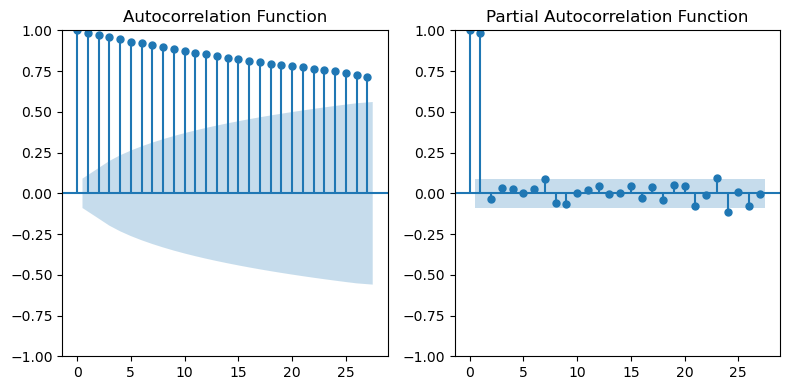

In [158]:
y = normalized_df['Close']
lag_acf = acf(y, nlags=25)
lag_pacf = pacf(y, nlags=25, method='ols')
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_acf(y, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.subplot(122)
plot_pacf(y, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [159]:
arima_model = ARIMA(y, order=(1,1,27))
arima_result = arima_model.fit()
print(arima_result.summary())
predictionsArima = arima_result.predict()

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  471
Model:                ARIMA(1, 1, 27)   Log Likelihood                1296.335
Date:                Thu, 09 May 2024   AIC                          -2534.671
Time:                        21:50:09   BIC                          -2414.241
Sample:                             0   HQIC                         -2487.291
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1483      0.417     -0.355      0.722      -0.966       0.670
ma.L1          0.0714      0.417      0.171      0.864      -0.746       0.889
ma.L2         -0.0308      0.045     -0.682      0.4

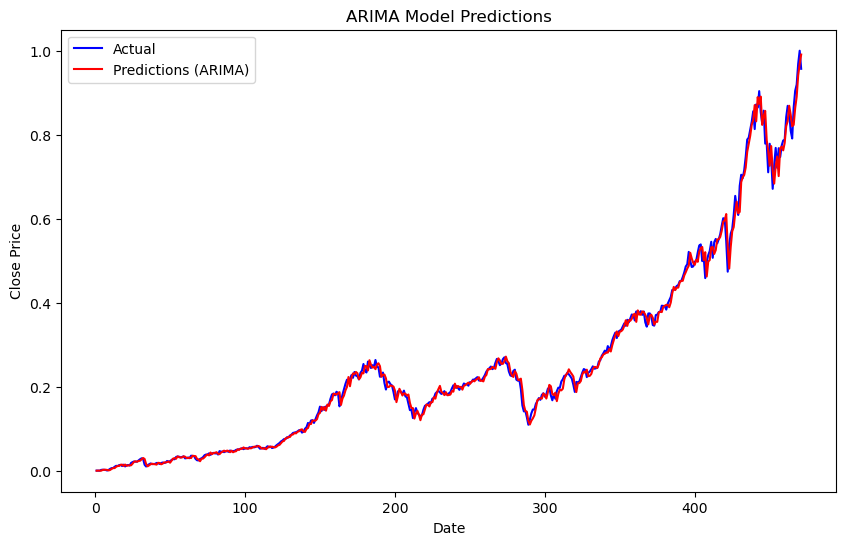

In [160]:
predictions_arima = arima_result.predict()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', color='blue')
plt.plot(y.index, predictions_arima, label='Predictions (ARIMA)', color='red')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [161]:
predictionsArima_aligned = predictionsArima[:-1]  #remove the last prediction to match the length of y
rmse_arima = np.sqrt(mean_squared_error(y[1:], predictionsArima_aligned))
mae_arima = mean_absolute_error(y[1:], predictionsArima_aligned)
mape_arima = np.mean(np.abs((y[1:] - predictionsArima_aligned) / y[1:])) * 100

print("ARIMA Performance Metrics:")
print("RMSE:", rmse_arima)
print("MAE:", mae_arima)
print("MAPE:", mape_arima)

ARIMA Performance Metrics:
RMSE: 0.021856323328632507
MAE: 0.013609296329176011
MAPE: 7.474625806956062


## ANN

In [166]:
X = normalized_df[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
y = normalized_df['Close']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
input_dim = X.shape[1]
model = Sequential()
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)


Epoch 1/5


C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.4923 - val_loss: 0.2357
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1106 - val_loss: 0.0453
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 - val_loss: 0.0063
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 8.5411e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8353e-04
Test Loss: 0.0008541123825125396


## SARIMA

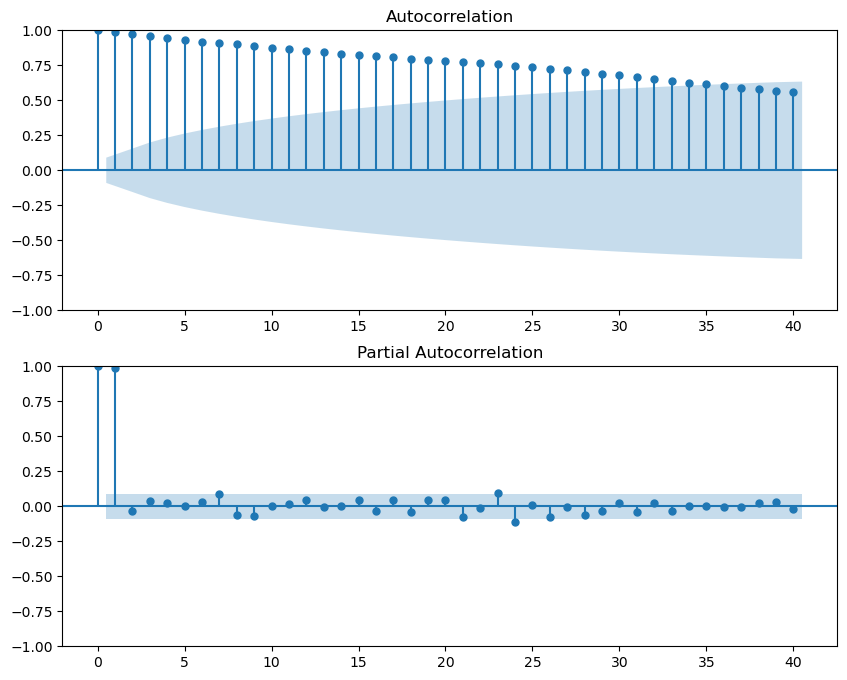

In [171]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(normalized_df['Close'], ax=ax[0], lags=40)
plot_pacf(normalized_df['Close'], ax=ax[1], lags=40)
plt.show()

# Calculate ACF and PACF values for further analysis
acf_values = acf(normalized_df['Close'], nlags=40)
pacf_values = pacf(normalized_df['Close'], nlags=40)


In [182]:
# SARIMA Model Identification
# Look for significant ACF and PACF values to determine SARIMA parameters
# Example: For non-seasonal parameters (p, d, q)
p = 1  # AR order (from PACF)
d = 1  # Differencing order (based on the differencing applied)
q = 27  # MA order (from ACF)

# Example: For seasonal parameters (P, D, Q, m)
P = 1  # Seasonal AR order (from seasonal PACF)
D = 1  # Seasonal differencing order (can be 0 or 1 based on the seasonality)
Q = 0  # Seasonal MA order (from seasonal ACF)
m = 12  # Seasonal period (12 for monthly data)

# Fit SARIMA model
model = SARIMAX(normalized_df['Close'], order=(p, d, q), seasonal_order=(P, D, Q, m))
results = model.fit()

# Display model summary
print(results.summary())

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  471
Model:             SARIMAX(1, 1, 27)x(1, 1, [], 12)   Log Likelihood                1242.855
Date:                              Thu, 09 May 2024   AIC                          -2425.709
Time:                                      21:58:57   BIC                          -2301.903
Sample:                                           0   HQIC                         -2376.948
                                              - 471                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1715      4.255     -0.040      0.968      -8.511       8.168
ma.L1          0.05

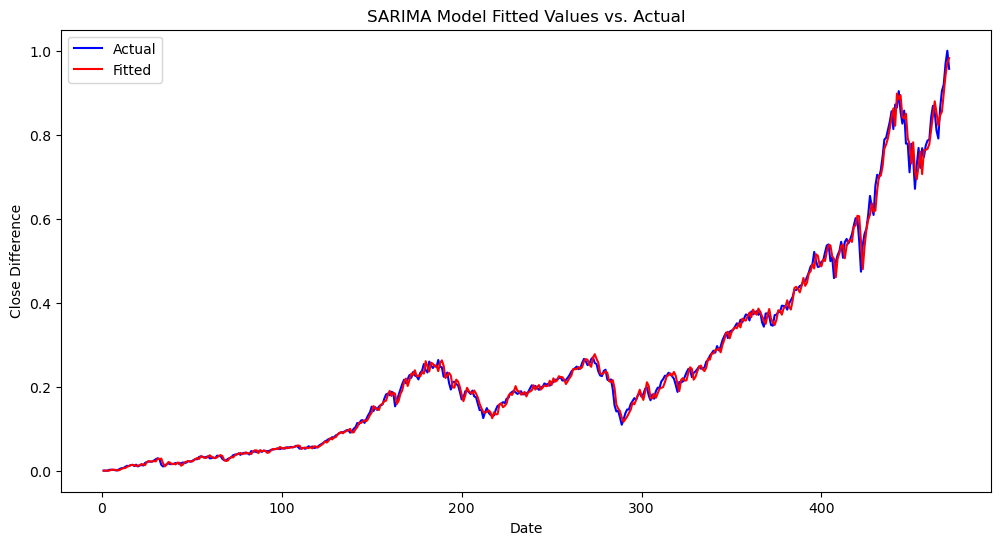

In [183]:
plt.figure(figsize=(12, 6))
plt.plot(normalized_df['Close'], label='Actual', color='blue')
fitted_values = results.fittedvalues
plt.plot(fitted_values, label='Fitted', color='red')
plt.title('SARIMA Model Fitted Values vs. Actual')
plt.xlabel('Date')
plt.ylabel('Close Difference')
plt.legend()
plt.show()

In [189]:
# Forecast Accuracy Metrics
forecast = results.get_forecast(steps=len(normalized_df))
predicted_values = forecast.predicted_mean
actual_values = normalized_df['Close']
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 1.677928949316712
Mean Squared Error: 2.9626608782159787
Root Mean Squared Error: 1.7212381817215126


C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## ETS

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


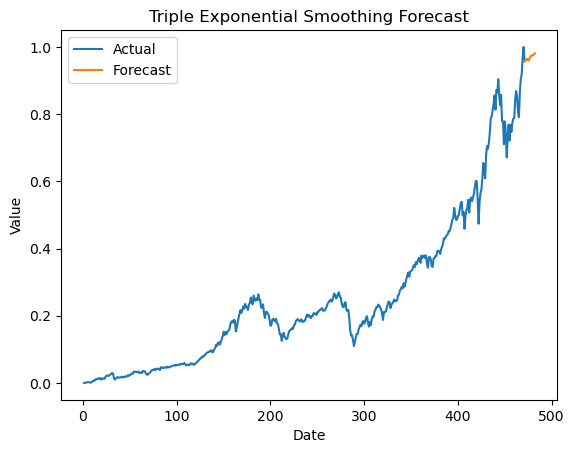

In [112]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(normalized_df['Close'], trend='add', seasonal='add', seasonal_periods=12)
results = model.fit()

# Forecast future values
forecast = results.forecast(steps=12)  # Forecast for the next 12 time periods
# Plot forecasted values
plt.plot(normalized_df.index, normalized_df['Close'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

In [113]:
actual_values = normalized_df['Close'][-12:]  # Actual values for the last 12 time periods
mae = mean_absolute_error(actual_values, forecast)
mse = mean_squared_error(actual_values, forecast)
rmse = np.sqrt(mse)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 0.09140861622616114
Mean Squared Error: 0.011327748762804525
Root Mean Squared Error: 0.106431897299656


## SVR

In [114]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr = SVR(kernel='rbf')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get best model from grid search
best_svr = grid_search.best_estimator_

# Fit best model to training data
best_svr.fit(X_train, y_train)

# Make predictions on testing data
predictions = best_svr.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.004652633564580203


## LSTM